In [0]:
!pip install tensorflow
!pip install h5py
!pip install sacred
!pip install pymongo
!pip install tensorboardX
!pip install bm3d
!pip install kornia

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!git clone https://github.com/bayesiains/nsf.git

fatal: destination path 'nsf' already exists and is not an empty directory.


In [0]:
import os
os.environ['DATASET_ROOT'] = '/content/nsf/data'
os.environ['DATAROOT'] = '/content/nsf/data'
os.chdir('/content/nsf/')

In [0]:
os.makedirs('/content/nsf/data/runs/images')

In [0]:
#@title Coos7py simple
%%writefile data/coos7.py

import torch
import h5py
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from numpy import newaxis
from PIL import Image
import cv2
import numpy as np
import pdb


class Cells(Dataset):
    """MRI knee dataset."""
    
    classes = ["0", "1", "2", "3", "4,", "5", "6"]

    def __init__(self, root, train=True, transform=None):
        """
        Args:
            images (4d array of images): images from the coos train file
            labels (array of ints): classes of the images
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        archive = h5py.File(root, "r")
        self.data = archive['imgs']
        self.labels = []
        self.tensimg = []

        
        # pdb.set_trace()
        for i in range(0,3668):
          img = self.data[i]
          newimg = abs(img)
          newimg = cv2.normalize(newimg,None,0,(2**8)-1,cv2.NORM_MINMAX,cv2.CV_8U)
          newimg = newimg.transpose(1, 0)
          scale_percent = 25 # percent of original size
          width = int(newimg.shape[1] * scale_percent / 100)
          height = int(newimg.shape[0] * scale_percent / 100)
          dim = (width, height)
          newimg2 = cv2.resize(newimg, dim, interpolation = cv2.INTER_AREA)
          self.width = newimg2.shape[1]
          self.height = newimg2.shape[0]
          newimg = np.array(newimg2)  
          newimg = torch.from_numpy(newimg[np.newaxis, :])
          self.tensimg.append(newimg)
          assert newimg.dtype == torch.uint8

        self.transform = transform

    def __len__(self):
        return len(self.tensimg)

    def __getitem__(self, idx):
      
        image = self.tensimg[idx]
        image_class = "label"
        if self.transform is not None:
            image = self.transform(image)
           
        return image, image_class

Overwriting data/coos7.py


In [0]:
#@title Config Coos7
%%writefile experiments/image_configs/coos7.json

{
  "actnorm": true,
  "alpha": 0.05,
  "batch_size": 9,
  "cosine_annealing": true,
  "coupling_layer_type": "rational_quadratic_spline",
  "dataset": "coos7",
  "dropout_prob": 0.0,
  "eta_min": 0.0,
  "hidden_channels": 612,
  "flow_checkpoint": "/content/drive/Shared drives/EE 461P Project/flow model/flow_best(4).pt",
  "intervals": {
    "eval": 100,
    "log": 20,
    "reconstruct": 1000,
    "sample": 360,
    "save": 100
  },
  "learning_rate": 0.0015,
  "levels": 4,
  "multi_gpu": false,
  "multi_scale": true,
  "num_bits": 4,
  "num_res_blocks": 12,
  "num_steps": 6000,
  "num_workers": 0,
  "optimizer_checkpoint": null,
  "pad": 2,
  "preprocessing": "glow",
  "resnet_batchnorm": true,
  "run_descr": "",
  "seed": 656493568,
  "spline_params": {
    "apply_unconditional_transform": false,
    "min_bin_height": 0.001,
    "min_bin_width": 0.001,
    "min_derivative": 0.001,
    "num_bins": 12,
    "tail_bound": 1.0
  },
  "start_step": 0,
  "steps_per_level": 10,
  "temperatures": [
    0.5,
    0.75,
    1.0
  ],
  "use_gpu": true,
  "use_resnet": false,
  "valid_frac": 0.1,
  "warmup_fraction": 0.0

}

Overwriting experiments/image_configs/coos7.json


In [0]:
#@title Images_data with coos7
%%writefile experiments/images_data.py

import os

import pdb

import torch
import numpy as np
from torchvision import transforms as tvt
from torchvision import datasets
from torch.utils.data import Subset, random_split

import matplotlib.pyplot as plt

import data
from experiments import autils

class Preprocess:
    def __init__(self, num_bits):
        self.num_bits = num_bits
        self.num_bins = 2 ** self.num_bits

    def __call__(self, img):
        if img.dtype == torch.uint8:
            img = img.float() # Already in [0,255]
        else:
            img = img * 255. # [0,1] -> [0,255]

        if self.num_bits != 8:
            img = torch.floor(img / 2 ** (8 - self.num_bits)) # [0, 255] -> [0, num_bins - 1]

        # Uniform dequantization.
        img = img + torch.rand_like(img)
        
        return img

    def inverse(self, inputs):
        # Discretize the pixel values.
        inputs = torch.floor(inputs)
        # Convert to a float in [0, 1].
        inputs = inputs * (256 / self.num_bins) / 255
        inputs = torch.clamp(inputs, 0, 1)
        return inputs

class RandomHorizontalFlipTensor(object):
    """Random horizontal flip of a CHW image tensor."""
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img):
        assert img.dim() == 3
        if np.random.rand() < self.p:
            return img.flip(2) # Flip the width dimension, assuming img shape is CHW.
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)

def dataset_root(dataset_name):
    return os.path.join(autils.get_dataset_root(), dataset_name)

def show_coos(image, label):
    """Show image with landmarks"""
    plt.imshow(image, cmap="Greys_r")
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.figure()
    plt.show()  
  
def get_data(dataset, num_bits, train=True, valid_frac=None):
    train_dataset = None
    valid_dataset = None
    test_dataset = None

    if train:
        assert valid_frac is not None

    if dataset == 'imagenet-64-fast':
        root = dataset_root('imagenet64_fast')
        c, h, w = (3, 64, 64)

        if train:
            train_dataset = data.ImageNet64Fast(
                root=root,
                train=True,
                download=True,
                transform=Preprocess(num_bits)
            )

            num_train = len(train_dataset)
            valid_size = int(np.floor(num_train * valid_frac))
            train_size = num_train - valid_size
            train_dataset, valid_dataset = random_split(train_dataset,
                                                        (train_size, valid_size))
        else:
            test_dataset = data.ImageNet64Fast(
                root=root,
                train=False,
                download=True,
                transform=Preprocess(num_bits)
            )

    elif dataset == 'cifar-10-fast' or dataset == 'cifar-10':
        root = dataset_root('cifar-10')
        c, h, w = (3, 32, 32)

        if dataset == 'cifar-10-fast':
            dataset_class = data.CIFAR10Fast
            train_transform = tvt.Compose([
                RandomHorizontalFlipTensor(),
                Preprocess(num_bits)
            ])
            test_transform = Preprocess(num_bits)
        else:
            dataset_class = datasets.CIFAR10
            train_transform=tvt.Compose([
                tvt.RandomHorizontalFlip(),
                tvt.ToTensor(),
                Preprocess(num_bits)
            ])
            test_transform = tvt.Compose([
                tvt.ToTensor(),
                Preprocess(num_bits)
            ])

        if train:
            train_dataset = dataset_class(
                root=root,
                train=True,
                download=True,
                transform=train_transform
            )

            valid_dataset = dataset_class(
                root=root,
                train=True,
                transform=test_transform # Note different transform.
            )

            num_train = len(train_dataset)
            indices = torch.randperm(num_train).tolist()
            valid_size = int(np.floor(valid_frac * num_train))
            train_idx, valid_idx = indices[valid_size:], indices[:valid_size]

            train_dataset = Subset(train_dataset, train_idx)
            valid_dataset = Subset(valid_dataset, valid_idx)
        else:
            test_dataset = dataset_class(
                root=root,
                train=False,
                download=True,
                transform=test_transform
            )
    elif dataset == 'imagenet-32' or dataset == 'imagenet-64':
        if dataset == 'imagenet-32':
            root = dataset_root('imagenet32')
            c, h, w = (3, 32, 32)
            dataset_class = data.ImageNet32
        else:
            root = dataset_root('imagenet64')
            c, h, w = (3, 64, 64)
            dataset_class = data.ImageNet64

        if train:
            train_dataset = dataset_class(
                root=root,
                train=True,
                download=True,
                transform=tvt.Compose([
                    tvt.ToTensor(),
                    Preprocess(num_bits)
                ])
            )

            num_train = len(train_dataset)
            valid_size = int(np.floor(num_train * valid_frac))
            train_size = num_train - valid_size
            train_dataset, valid_dataset = random_split(train_dataset,
                                                        (train_size, valid_size))
        else:
            test_dataset = dataset_class(
                root=root,
                train=False,
                download=True,
                transform=tvt.Compose([
                    tvt.ToTensor(),
                    Preprocess(num_bits)
                ])
            )
    elif dataset == 'celeba-hq-64-fast':
        root = dataset_root('celeba_hq_64_fast')
        c, h, w = (3, 64, 64)

        train_transform = tvt.Compose([
            RandomHorizontalFlipTensor(),
            Preprocess(num_bits)
        ])
        test_transform = Preprocess(num_bits)

        if train:
            train_dataset = data.CelebAHQ64Fast(
                root=root,
                train=True,
                download=True,
                transform=train_transform
            )

            valid_dataset = data.CelebAHQ64Fast(
                root=root,
                train=True,
                transform=test_transform # Note different transform.
            )

            num_train = len(train_dataset)
            indices = torch.randperm(num_train).tolist()
            valid_size = int(np.floor(5))
            train_idx, valid_idx = indices[valid_size:], indices[:valid_size]

            train_dataset = Subset(train_dataset, train_idx)
            valid_dataset = Subset(valid_dataset, valid_idx)
        else:
            test_dataset = data.CelebAHQ64Fast(
                root=root,
                train=False,
                download=True,
                transform=test_transform
            )
            
    elif dataset == 'coos7':
        root = dataset_root("/content/drive/Shared drives/EE 461P Project/Dataset/dataset_train_knees.h5")
        pad = 13
        c, h, w = (1, 80, 64)

        train_transform = tvt.Compose([                           
            Preprocess(num_bits)
        ])
        test_transform = Preprocess(num_bits)

        if train:
            train_dataset = data.Cells(
                root=root,
                train=True,
                transform=train_transform
            )

            valid_dataset = data.Cells(
                root=root,
                train=True,
                transform=test_transform # Note different transform.
            )

            h = train_dataset.height
            w = train_dataset.width
            print(h)
            print(w)
            num_train = len(train_dataset)
            indices = torch.randperm(num_train).tolist()
            valid_size = int(np.floor(481))
            train_idx, valid_idx = indices[valid_size:], indices[:valid_size]

            train_dataset = Subset(train_dataset, train_idx)
            valid_dataset = Subset(valid_dataset, valid_idx)
        else:
            train_dataset = data.Cells(
                root=root,
                train=True,
                transform=train_transform
            )

            valid_dataset = data.Cells(
                root=root,
                train=True,
                transform=test_transform # Note different transform.
            )

            h = train_dataset.height
            w = train_dataset.width
            print(h)
            print(w)
            num_train = len(train_dataset)
            indices = torch.randperm(num_train).tolist()
            valid_size = int(np.floor(481))
            train_idx, valid_idx = indices[valid_size:], indices[:valid_size]

            train_dataset = Subset(train_dataset, train_idx)
            valid_dataset = Subset(valid_dataset, valid_idx)

    # if dataset_name == 'fashion-mnist' or dataset_name == 'mnist':
    #     base_transforms = [
    #         tvt.Pad((pad, pad)),
    #         tvt.ToTensor()
    #     ]
    #
    #     root = dataset_root(dataset_name)
    #
    #     c, h, w = (1, 28 + 2 * pad, 28 + 2 * pad)
    #
    #     if dataset_name == 'fashion-mnist':
    #         dataset_cls = datasets.FashionMNIST
    #         base_transforms.insert(0, tvt.RandomHorizontalFlip())
    #     else:
    #         dataset_cls = datasets.MNIST
    #
    #     dataset = dataset_cls(
    #         root=root,
    #         train=train,
    #         transform=tvt.Compose(
    #             base_transforms + [Preprocess(num_bits, jitter=train)]
    #         ),
    #         download=True
    #     )
    #
    # elif dataset_name == 'celeba-64':
    #     if not train:
    #         raise RuntimeError('No test set for CelebA.')
    #
    #     root = dataset_root('celeba')
    #     c, h, w = (3, 64, 64)
    #     dataset = data.CelebA(
    #         root=root,
    #         transform=tvt.Compose([
    #             tvt.CenterCrop(148),
    #             tvt.Resize(64),
    #             tvt.RandomHorizontalFlip(),
    #             tvt.ToTensor(),
    #             Preprocess(num_bits)
    #         ]),
    #         download=True
    #     )
    #
    # elif dataset_name == 'celeba-hq-64':
    #     if not train:
    #         raise RuntimeError('No test set for CelebA.')
    #
    #     root = dataset_root('celeba-hq')
    #     c, h, w = (3, 64, 64)
    #     dataset = data.CelebAHQ(
    #         root=root,
    #         transform=tvt.Compose([
    #             tvt.Resize(64),
    #             tvt.RandomHorizontalFlip(),
    #             tvt.ToTensor(),
    #             Preprocess(num_bits)
    #         ]),
    #         download=True
    #     )
    #

    elif dataset == 'fashion-mnist' or dataset == 'mnist-fast':
       
        pad = 2
        
        base_transforms = [
            tvt.Pad((pad, pad)),
            tvt.ToTensor()
        ]
    
        root = dataset_root('mnist')
    
        c, h, w = (1, 28 + 2 * pad, 28 + 2 * pad)
    
        if dataset == 'fashion-mnist':
            dataset_cls = datasets.FashionMNIST
            base_transforms.insert(0, tvt.RandomHorizontalFlip())
        else:
            dataset_cls = data.MNIST

        if train:    
            train_dataset = dataset_cls(
                root=root,
                train=train,
                transform=tvt.Compose(
                  base_transforms + [Preprocess(num_bits)]
                ),
                download=True
            )


            test_transform = tvt.Compose([
                    tvt.Pad((pad, pad)),
                    tvt.ToTensor(),
                   Preprocess(num_bits)
            ])


            valid_dataset = dataset_cls(
                 root=root,
                 train=True,
                 transform=test_transform # Note different transform.
            )
          
            num_train = len(train_dataset)

            indices = torch.randperm(num_train).tolist()
            
            valid_size = int(np.floor(valid_frac * num_train))
        
            train_idx, valid_idx = indices[valid_size:], indices[:valid_size]

            train_dataset = Subset(train_dataset, train_idx)
            valid_dataset = Subset(valid_dataset, valid_idx)

        else:
          
            test_transform = tvt.Compose([
                    tvt.Pad((pad, pad)),
                    tvt.ToTensor(),
                   Preprocess(num_bits)
            ])


            test_dataset = dataset_cls(
                root=root,
                train=False,
                download=True,
                transform=test_transform
            )
    
    else:
        raise RuntimeError('Unknown dataset')

    if train:
        return train_dataset, valid_dataset, (c, h, w)
    else:
        return valid_dataset, (c, h, w)


Overwriting experiments/images_data.py


In [0]:
#@title init py
%%writefile data/__init__.py


from .base import (
    get_uci_dataset_range,
    get_uci_dataset_max_abs_value,
    load_dataset,
    load_plane_dataset,
    load_face_dataset,
    batch_generator,
    InfiniteLoader,
    load_num_batches,
    UnlabelledImageFolder
)
from data.download import download_file, download_file_from_google_drive

from .plane import TestGridDataset

from .celeba import CelebA, CelebAHQ, CelebAHQ64Fast

from .imagenet import ImageNet32, ImageNet64, ImageNet64Fast

from .cifar10 import CIFAR10Fast

from .omniglot import OmniglotDataset

from .coos7 import Cells

from .mnist import*


Overwriting data/__init__.py


In [0]:
#@title MNISTpy
%%writefile data/mnist.py

from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import datasets
from torchvision.utils import *
from torchvision.datasets import VisionDataset
from torchvision.datasets import utils

from torchvision.datasets.utils import download_url

from PIL import Image
import os
import os.path
import gzip
import numpy as np
import torch
import pdb
import codecs
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


class MNIST(VisionDataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``MNIST/processed/training.pt``
            and  ``MNIST/processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
    
#     def makedir_exist_ok(dirpath):
#       try:
#           os.makedirs(dirpath)
#         except OSError as e:
#         if e.errno == errno.EEXIST:
#           pass
#         else:
#           raise

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(MNIST, self).__init__(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        
        pdb.set_trace()
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return (os.path.exists(os.path.join(self.processed_folder,
                                            self.training_file)) and
                os.path.exists(os.path.join(self.processed_folder,
                                            self.test_file)))

    @staticmethod
    def extract_gzip(gzip_path, remove_finished=False):
        print('Extracting {}'.format(gzip_path))
        with open(gzip_path.replace('.gz', ''), 'wb') as out_f, \
                gzip.GzipFile(gzip_path) as zip_f:
            out_f.write(zip_f.read())
        if remove_finished:
            os.unlink(gzip_path)

    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""

        if self._check_exists():
            return

        makedir_exist_ok(self.raw_folder)
        makedir_exist_ok(self.processed_folder)

        # download files
        for url in self.urls:
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.raw_folder, filename)
            download_url(url, root=self.raw_folder, filename=filename, md5=None)
            self.extract_gzip(gzip_path=file_path, remove_finished=True)

        # process and save as torch files
        print('Processing...')

        training_set = (
            read_image_file(os.path.join(self.raw_folder, 'train-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 'train-labels-idx1-ubyte'))
        )
        test_set = (
            read_image_file(os.path.join(self.raw_folder, 't10k-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 't10k-labels-idx1-ubyte'))
        )
        with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def extra_repr(self):
        return "Split: {}".format("Train" if self.train is True else "Test")



class FashionMNIST(MNIST):
    """`Fashion-MNIST <https://github.com/zalandoresearch/fashion-mnist>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``Fashion-MNIST/processed/training.pt``
            and  ``Fashion-MNIST/processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
    ]
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



class KMNIST(MNIST):
    """`Kuzushiji-MNIST <https://github.com/rois-codh/kmnist>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``KMNIST/processed/training.pt``
            and  ``KMNIST/processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
        'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
        'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
        'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
        'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz',
    ]
    classes = ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']



class EMNIST(MNIST):
    """`EMNIST <https://www.westernsydney.edu.au/bens/home/reproducible_research/emnist>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``EMNIST/processed/training.pt``
            and  ``EMNIST/processed/test.pt`` exist.
        split (string): The dataset has 6 different splits: ``byclass``, ``bymerge``,
            ``balanced``, ``letters``, ``digits`` and ``mnist``. This argument specifies
            which one to use.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    # Updated URL from https://www.westernsydney.edu.au/bens/home/reproducible_research/emnist
    url = 'https://cloudstor.aarnet.edu.au/plus/index.php/s/54h3OuGJhFLwAlQ/download'
    splits = ('byclass', 'bymerge', 'balanced', 'letters', 'digits', 'mnist')

    def __init__(self, root, split, **kwargs):
        if split not in self.splits:
            raise ValueError('Split "{}" not found. Valid splits are: {}'.format(
                split, ', '.join(self.splits),
            ))
        self.split = split
        self.training_file = self._training_file(split)
        self.test_file = self._test_file(split)
        super(EMNIST, self).__init__(root, **kwargs)

    @staticmethod
    def _training_file(split):
        return 'training_{}.pt'.format(split)

    @staticmethod
    def _test_file(split):
        return 'test_{}.pt'.format(split)

    def download(self):
        """Download the EMNIST data if it doesn't exist in processed_folder already."""
        import shutil
        import zipfile

        if self._check_exists():
            return

        makedir_exist_ok(self.raw_folder)
        makedir_exist_ok(self.processed_folder)

        # download files
        filename = self.url.rpartition('/')[2]
        file_path = os.path.join(self.raw_folder, filename)
        download_url(self.url, root=self.raw_folder, filename=filename, md5=None)

        print('Extracting zip archive')
        with zipfile.ZipFile(file_path) as zip_f:
            zip_f.extractall(self.raw_folder)
        os.unlink(file_path)
        gzip_folder = os.path.join(self.raw_folder, 'gzip')
        for gzip_file in os.listdir(gzip_folder):
            if gzip_file.endswith('.gz'):
                self.extract_gzip(gzip_path=os.path.join(gzip_folder, gzip_file))

        # process and save as torch files
        for split in self.splits:
            print('Processing ' + split)
            training_set = (
                read_image_file(os.path.join(gzip_folder, 'emnist-{}-train-images-idx3-ubyte'.format(split))),
                read_label_file(os.path.join(gzip_folder, 'emnist-{}-train-labels-idx1-ubyte'.format(split)))
            )
            test_set = (
                read_image_file(os.path.join(gzip_folder, 'emnist-{}-test-images-idx3-ubyte'.format(split))),
                read_label_file(os.path.join(gzip_folder, 'emnist-{}-test-labels-idx1-ubyte'.format(split)))
            )
            with open(os.path.join(self.processed_folder, self._training_file(split)), 'wb') as f:
                torch.save(training_set, f)
            with open(os.path.join(self.processed_folder, self._test_file(split)), 'wb') as f:
                torch.save(test_set, f)
        shutil.rmtree(gzip_folder)

        print('Done!')



def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)


def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
        return torch.from_numpy(parsed).view(length).long()


def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
        return torch.from_numpy(parsed).view(length, num_rows, num_cols)

Overwriting data/mnist.py


In [0]:
#@title images.py
%%writefile experiments/images.py

import os
import time
import pdb

import numpy as np
import scipy.misc
import sacred

import torch
from torch import nn

from sacred import Experiment, observers
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
from tqdm import tqdm

from experiments import autils
from experiments.autils import Conv2dSameSize, LogProbWrapper
from experiments.images_data import get_data, Preprocess

from data import load_num_batches
from torchvision.utils import make_grid, save_image

from nde import distributions, transforms, flows
import utils
import optim
import nn as nn_

import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt

# Capture job id on the cluster
sacred.SETTINGS.HOST_INFO.CAPTURED_ENV.append('SLURM_JOB_ID')

runs_dir = os.path.join(utils.get_data_root(), 'runs/images')
ex = Experiment('decomposition-flows-images')

fso = observers.FileStorageObserver.create(runs_dir, priority=1)
# I don't like how sacred names run folders.
ex.observers.extend([fso, autils.NamingObserver(runs_dir, priority=2)])

# For num_workers > 0 and tensor datasets, bad things happen otherwise.
torch.multiprocessing.set_start_method("spawn", force=True)

# noinspection PyUnusedLocal
@ex.config
def config():
    # Dataset
    dataset = 'fashion-mnist'
    num_workers = 0
    valid_frac = 0.01

    # Pre-processing
    preprocessing = 'glow'
    alpha = .05
    num_bits = 8
    pad = 2 # For mnist-like datasets

    # Model architecture
    steps_per_level = 10
    levels = 3
    multi_scale=True
    actnorm = True

    # Coupling transform
    coupling_layer_type = 'rational_quadratic_spline'
    spline_params = {
        'num_bins': 4,
        'tail_bound': 1.,
        'min_bin_width': 1e-3,
        'min_bin_height': 1e-3,
        'min_derivative': 1e-3,
        'apply_unconditional_transform': False
    }

    # Coupling transform net
    hidden_channels = 256
    use_resnet = False
    num_res_blocks = 5 # If using resnet
    resnet_batchnorm = True
    dropout_prob = 0.

    # Optimization
    batch_size = 256
    learning_rate = 5e-4
    cosine_annealing = True
    eta_min=0.
    warmup_fraction = 0.
    num_steps = 100000
    temperatures = [0.5, 0.75, 1.]

    # Training logistics
    use_gpu = True
    multi_gpu = False
    run_descr = ''
    flow_checkpoint = None
    optimizer_checkpoint = None
    start_step = 0

    intervals = {
        'save': 1000,
        'sample': 1000,
        'eval': 1000,
        'reconstruct': 1000,
        'log': 10 # Very cheap.
    }

    # For evaluation
    num_samples = 64
    samples_per_row = 8
    num_reconstruct_batches = 10

class ConvNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.net = nn.Sequential(
            Conv2dSameSize(in_channels, hidden_channels, kernel_size=3),
            nn.ReLU(),
            Conv2dSameSize(hidden_channels, hidden_channels, kernel_size=1),
            nn.ReLU(),
            Conv2dSameSize(hidden_channels, out_channels, kernel_size=3),
        )

    def forward(self, inputs, context=None):
        return self.net.forward(inputs)

@ex.capture
def create_transform_step(num_channels,
                          hidden_channels, actnorm, coupling_layer_type, spline_params,
                          use_resnet, num_res_blocks, resnet_batchnorm, dropout_prob):
    if use_resnet:
        def create_convnet(in_channels, out_channels):
            net = nn_.ConvResidualNet(in_channels=in_channels,
                                      out_channels=out_channels,
                                      hidden_channels=hidden_channels,
                                      num_blocks=num_res_blocks,
                                      use_batch_norm=resnet_batchnorm,
                                      dropout_probability=dropout_prob)
            return net
    else:
        if dropout_prob != 0.:
            raise ValueError()
        def create_convnet(in_channels, out_channels):
            return ConvNet(in_channels, hidden_channels, out_channels)

    mask = utils.create_mid_split_binary_mask(num_channels)

    if coupling_layer_type == 'cubic_spline':
        coupling_layer = transforms.PiecewiseCubicCouplingTransform(
            mask=mask,
            transform_net_create_fn=create_convnet,
            tails='linear',
            tail_bound=spline_params['tail_bound'],
            num_bins=spline_params['num_bins'],
            apply_unconditional_transform=spline_params['apply_unconditional_transform'],
            min_bin_width=spline_params['min_bin_width'],
            min_bin_height=spline_params['min_bin_height']
        )
    elif coupling_layer_type == 'quadratic_spline':
        coupling_layer = transforms.PiecewiseQuadraticCouplingTransform(
            mask=mask,
            transform_net_create_fn=create_convnet,
            tails='linear',
            tail_bound=spline_params['tail_bound'],
            num_bins=spline_params['num_bins'],
            apply_unconditional_transform=spline_params['apply_unconditional_transform'],
            min_bin_width=spline_params['min_bin_width'],
            min_bin_height=spline_params['min_bin_height']
        )
    elif coupling_layer_type == 'rational_quadratic_spline':
        coupling_layer = transforms.PiecewiseRationalQuadraticCouplingTransform(
            mask=mask,
            transform_net_create_fn=create_convnet,
            tails='linear',
            tail_bound=spline_params['tail_bound'],
            num_bins=spline_params['num_bins'],
            apply_unconditional_transform=spline_params['apply_unconditional_transform'],
            min_bin_width=spline_params['min_bin_width'],
            min_bin_height=spline_params['min_bin_height'],
            min_derivative=spline_params['min_derivative']
        )
    elif coupling_layer_type == 'affine':
        coupling_layer = transforms.AffineCouplingTransform(
            mask=mask,
            transform_net_create_fn=create_convnet
        )
    elif coupling_layer_type == 'additive':
        coupling_layer = transforms.AdditiveCouplingTransform(
            mask=mask,
            transform_net_create_fn=create_convnet
        )
    else:
        raise RuntimeError('Unknown coupling_layer_type')

    step_transforms = []

    if actnorm:
        step_transforms.append(transforms.ActNorm(num_channels))

    step_transforms.extend([
        transforms.OneByOneConvolution(num_channels),
        coupling_layer
    ])

    return transforms.CompositeTransform(step_transforms)


@ex.capture
def create_transform(c, h, w,
                     levels, hidden_channels, steps_per_level, alpha, num_bits, preprocessing,
                     multi_scale):
    if not isinstance(hidden_channels, list):
        hidden_channels = [hidden_channels] * levels

    if multi_scale:
        mct = transforms.MultiscaleCompositeTransform(num_transforms=levels)
        for level, level_hidden_channels in zip(range(levels), hidden_channels):
            squeeze_transform = transforms.SqueezeTransform()
            c, h, w = squeeze_transform.get_output_shape(c, h, w)

            transform_level = transforms.CompositeTransform(
                [squeeze_transform]
                + [create_transform_step(c, level_hidden_channels) for _ in range(steps_per_level)]
                + [transforms.OneByOneConvolution(c)] # End each level with a linear transformation.
            )

            new_shape = mct.add_transform(transform_level, (c, h, w))
            if new_shape:  # If not last layer
                c, h, w = new_shape
    else:
        all_transforms = []

        for level, level_hidden_channels in zip(range(levels), hidden_channels):
            squeeze_transform = transforms.SqueezeTransform()
            c, h, w = squeeze_transform.get_output_shape(c, h, w)

            transform_level = transforms.CompositeTransform(
                [squeeze_transform]
                + [create_transform_step(c, level_hidden_channels) for _ in range(steps_per_level)]
                + [transforms.OneByOneConvolution(c)] # End each level with a linear transformation.
            )
            all_transforms.append(transform_level)

        all_transforms.append(transforms.ReshapeTransform(
            input_shape=(c,h,w),
            output_shape=(c*h*w,)
        ))
        mct = transforms.CompositeTransform(all_transforms)

    # Inputs to the model in [0, 2 ** num_bits]

    if preprocessing == 'glow':
        # Map to [-0.5,0.5]
        preprocess_transform = transforms.AffineScalarTransform(scale=(1. / 2 ** num_bits),
                                                                shift=-0.5)
    elif preprocessing == 'realnvp':
        preprocess_transform = transforms.CompositeTransform([
            # Map to [0,1]
            transforms.AffineScalarTransform(scale=(1. / 2 ** num_bits)),
            # Map into unconstrained space as done in RealNVP
            transforms.AffineScalarTransform(shift=alpha,
                                             scale=(1 - alpha)),
            transforms.Logit()
        ])

    elif preprocessing == 'realnvp_2alpha':
        preprocess_transform = transforms.CompositeTransform([
            transforms.AffineScalarTransform(scale=(1. / 2 ** num_bits)),
            transforms.AffineScalarTransform(shift=alpha,
                                             scale=(1 - 2. * alpha)),
            transforms.Logit()
        ])
    else:
        raise RuntimeError('Unknown preprocessing type: {}'.format(preprocessing))

    return transforms.CompositeTransform([preprocess_transform, mct])

@ex.capture
def create_flow(c, h, w,
                flow_checkpoint, _log):
    distribution = distributions.StandardNormal((c * h * w,))
    transform = create_transform(c, h, w)

    flow = flows.Flow(transform, distribution)

    _log.info('There are {} trainable parameters in this model.'.format(
        utils.get_num_parameters(flow)))

    if flow_checkpoint is not None:
        flow.load_state_dict(torch.load(flow_checkpoint))
        _log.info('Flow state loaded from {}'.format(flow_checkpoint))

    return flow

@ex.capture
def train_flow(flow, train_dataset, val_dataset, dataset_dims, device,
               batch_size, num_steps, learning_rate, cosine_annealing, warmup_fraction,
               temperatures, num_bits, num_workers, intervals, multi_gpu, actnorm,
               optimizer_checkpoint, start_step, eta_min, _log):
    run_dir = fso.dir

    flow = flow.to(device)

    summary_writer = SummaryWriter(run_dir, max_queue=100)

    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers)

    if val_dataset:
        val_loader = DataLoader(dataset=val_dataset,
                                batch_size=batch_size,
                                num_workers=num_workers)
    else:
        val_loader = None

    # Random batch and identity transform for reconstruction evaluation.
    random_batch, _ = next(iter(DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=0 # Faster than starting all workers just to get a single batch.
    )))
    identity_transform = transforms.CompositeTransform([
        flow._transform,
        transforms.InverseTransform(flow._transform)
    ])

    # pdb.set_trace()
    # for param in flow.parameters():
    #   p = param;

    # print(p)
    # # p.requires_grad = False

    # i=0;

    # for param in flow.parameters():
    #     i = i+1
    #     if param.nelement()>0:
    #       if(i<400):
    #         param.requires_grad=False

    # p.requires_grad = True
    # print(p)
    # print

    optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

    if optimizer_checkpoint is not None:
        optimizer.load_state_dict(torch.load(optimizer_checkpoint))
        _log.info('Optimizer state loaded from {}'.format(optimizer_checkpoint))

    if cosine_annealing:
        if warmup_fraction == 0.:
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer=optimizer,
                T_max=num_steps/7,
                last_epoch=-1 if start_step == 0 else start_step,
                eta_min=eta_min
            )
        else:
            scheduler = optim.CosineAnnealingWarmUpLR(
                optimizer=optimizer,
                warm_up_epochs=int(warmup_fraction * num_steps),
                total_epochs=num_steps/7,
                last_epoch=-1 if start_step == 0 else start_step,
                eta_min=eta_min
            )
    else:
        scheduler = None

    #scheduler.load_state_dict(torch.load("/content/nsf/data/runs/images/cifar-10-fast-5-bit-1/scheduler_last.pt"))
    
    
    def nats_to_bits_per_dim(x):
        c, h, w = dataset_dims
        return autils.nats_to_bits_per_dim(x, c, h, w)

    _log.info('Starting training...')

    best_val_log_prob = None
    start_time = time.time()
    num_batches = num_steps - start_step
    
    listlr = [1.0]
    
    
    
#     for param_group in optimizer.param_groups:
#            param_group['lr'] = 0.0005868240888334653

    #pdb.set_trace()

    for step, (batch, _) in enumerate(load_num_batches(loader=train_loader,
                                                       num_batches=num_batches),
                                      start=start_step):
        if step == 0:
            start_time = time.time() # Runtime estimate will be more accurate if set here.

        flow.train()

        optimizer.zero_grad()

        batch = batch.to(device)

        if multi_gpu:
            if actnorm and step == 0:
                # Is using actnorm, data-dependent initialization doesn't work with data_parallel,
                # so pass a single batch on a single GPU before the first step.
                flow.log_prob(
                    batch[:batch.shape[0] // torch.cuda.device_count(), ...]
                )

            # Split along the batch dimension and put each split on a separate GPU. All available
            # GPUs are used.
            log_density = nn.parallel.data_parallel(LogProbWrapper(flow), batch)
        else:
            log_density = flow.log_prob(batch)

        loss = -nats_to_bits_per_dim(torch.mean(log_density))

        loss.backward()
        optimizer.step()
        
        for param_group in optimizer.param_groups:
              listlr.append(param_group['lr'])

        if scheduler is not None:
            if step % 7 ==0 :
                scheduler.step()
                summary_writer.add_scalar('learning_rate', scheduler.get_lr()[0], step)

        summary_writer.add_scalar('loss', loss.item(), step)

        if best_val_log_prob:
            summary_writer.add_scalar('best_val_log_prob', best_val_log_prob, step)

        flow.eval() # Everything beyond this point is evaluation.

        if step % intervals['log'] == 0:
            elapsed_time = time.time() - start_time
            progress = autils.progress_string(elapsed_time, step, num_steps)
            _log.info("It: {}/{} loss: {:.3f} [{}]".format(step, num_steps, loss, progress))

        # if step % intervals['sample'] == 0:
        #     fig, axs = plt.subplots(1, len(temperatures), figsize=(4 * len(temperatures), 4))
        #     for temperature, ax in zip(temperatures, axs.flat):
        #         with torch.no_grad():
        #             noise = flow._distribution.sample(64) * temperature
        #             samples, _ = flow._transform.inverse(noise)
        #             samples = Preprocess(num_bits).inverse(samples)

        #         autils.imshow(make_grid(samples, nrow=8), ax)

        #         ax.set_title('T={:.2f}'.format(temperature))

        #     summary_writer.add_figure(tag='samples', figure=fig, global_step=step)

        #     plt.close(fig)

        if step > 0 and step % intervals['eval'] == 0 and (val_loader is not None):
            if multi_gpu:
                def log_prob_fn(batch):
                    return nn.parallel.data_parallel(LogProbWrapper(flow),
                                                     batch.to(device))
            else:
                def log_prob_fn(batch):
                    return flow.log_prob(batch.to(device))

            val_log_prob = autils.eval_log_density(log_prob_fn=log_prob_fn,
                                                   data_loader=val_loader)
            val_log_prob = nats_to_bits_per_dim(val_log_prob).item()

            _log.info("It: {}/{} val_log_prob: {:.3f}".format(step, num_steps, val_log_prob))
            summary_writer.add_scalar('val_log_prob', val_log_prob, step)

            if best_val_log_prob is None or val_log_prob > best_val_log_prob:
                best_val_log_prob = val_log_prob

                torch.save(flow.state_dict(), os.path.join(run_dir, 'flow_best.pt'))
                _log.info('It: {}/{} best val_log_prob improved, saved flow_best.pt'
                          .format(step, num_steps))

        if step > 0 and (step % intervals['save'] == 0 or step == (num_steps - 1)):
            torch.save(optimizer.state_dict(), os.path.join(run_dir, 'optimizer_last.pt'))
            torch.save(flow.state_dict(), os.path.join(run_dir, 'flow_last.pt'))
            torch.save(scheduler.state_dict(), os.path.join(run_dir, 'scheduler_last.pt') )
            print(scheduler.last_epoch)
            print(scheduler.state_dict())
            print(optimizer)
            print(listlr[-1])
            _log.info('It: {}/{} saved optimizer_last.pt and flow_last.pt'.format(step, num_steps))

        if step > 0 and step % intervals['reconstruct'] == 0:
            with torch.no_grad():
                random_batch_ = random_batch.to(device)
                random_batch_rec, logabsdet = identity_transform(random_batch_)

                max_abs_diff = torch.max(torch.abs(random_batch_rec - random_batch_))
                max_logabsdet = torch.max(logabsdet)

            # fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            # autils.imshow(make_grid(Preprocess(num_bits).inverse(random_batch[:36, ...]),
            #                         nrow=6), axs[0])
            # autils.imshow(make_grid(Preprocess(num_bits).inverse(random_batch_rec[:36, ...]),
            #                         nrow=6), axs[1])
            # summary_writer.add_figure(tag='reconstr', figure=fig, global_step=step)
            # plt.close(fig)

            summary_writer.add_scalar(tag='max_reconstr_abs_diff',
                                      scalar_value=max_abs_diff.item(),
                                      global_step=step)
            summary_writer.add_scalar(tag='max_reconstr_logabsdet',
                                      scalar_value=max_logabsdet.item(),
                                      global_step=step)

@ex.capture
def set_device(use_gpu, multi_gpu, _log):
    # Decide which device to use.
    if use_gpu and not torch.cuda.is_available():
        raise RuntimeError('use_gpu is True but CUDA is not available')

    if use_gpu:
        device = torch.device('cuda')
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    else:
        device = torch.device('cpu')

    if multi_gpu and torch.cuda.device_count() == 1:
        raise RuntimeError('Multiple GPU training requested, but only one GPU is available.')

    if multi_gpu:
        _log.info('Using all {} GPUs available'.format(torch.cuda.device_count()))

    return device

@ex.capture
def get_train_valid_data(dataset, num_bits, valid_frac):
    return get_data(dataset, num_bits, train=True, valid_frac=valid_frac)

@ex.capture
def get_test_data(dataset, num_bits):
    return get_data(dataset, num_bits, train=False)

@ex.command
def sample_for_paper(seed):
    run_dir = fso.dir

    sample(output_path=os.path.join(run_dir, 'samples_small.png'),
           num_samples=30,
           samples_per_row=10)

    sample(output_path=os.path.join(run_dir, 'samples_big.png'),
           num_samples=100,
           samples_per_row=10,
           seed=seed + 1)

@ex.command(unobserved=True)
def eval_on_test(batch_size, num_workers, seed, _log):
    torch.manual_seed(seed)
    np.random.seed(seed)

    device = set_device()
    test_dataset, (c, h, w) = get_test_data()
    _log.info('Test dataset size: {}'.format(len(test_dataset)))
    _log.info('Image dimensions: {}x{}x{}'.format(c, h, w))

    flow = create_flow(c, h, w).to(device)

    flow.eval()

    def log_prob_fn(batch):
        return flow.log_prob(batch.to(device))

    test_loader=DataLoader(dataset=test_dataset,
                           batch_size=batch_size,
                           num_workers=num_workers)
    test_loader = tqdm(test_loader)

    mean, err = autils.eval_log_density_2(log_prob_fn=log_prob_fn,
                                          data_loader=test_loader,
                                          c=c, h=h, w=w)
    print('Test log probability (bits/dim): {:.2f} +/- {:.4f}'.format(mean, err))

@ex.command(unobserved=True)
def sample(seed, num_bits, num_samples, samples_per_row, _log, output_path=None):
    torch.set_grad_enabled(False)

    if output_path is None:
        output_path = 'samples.png'

    torch.manual_seed(seed-1000)
    np.random.seed(seed-1000)

    device = set_device()

    _, _, (c, h, w) = get_train_valid_data()

    flow = create_flow(c, h, w).to(device)
    flow.eval()

    preprocess = Preprocess(num_bits)
    # pdb.set_trace()
    samples = flow.sample(9)
    samples = preprocess.inverse(samples)

    save_image(samples.cpu(), output_path,
               nrow=3,
               padding=0)

@ex.command(unobserved=True)
def num_params(_log):
    _, _, (c, h, w) = get_train_valid_data()
    # c, h, w = 3, 256, 256
    create_flow(c, h, w)

@ex.command(unobserved=True)
def eval_reconstruct(num_bits, batch_size, seed, num_reconstruct_batches, _log, output_path=''):
    torch.set_grad_enabled(False)

    device = set_device()

    torch.manual_seed(seed)
    np.random.seed(seed)

    train_dataset, _, (c, h, w) = get_train_valid_data()

    flow = create_flow(c, h, w).to(device)
    flow.eval()

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    identity_transform = transforms.CompositeTransform([
        flow._transform,
        transforms.InverseTransform(flow._transform)
    ])

    first_batch = True
    abs_diff = []
    for batch,_ in tqdm(load_num_batches(train_loader, num_reconstruct_batches),
                        total=num_reconstruct_batches):
        batch = batch.to(device)
        batch_rec, _ = identity_transform(batch)
        abs_diff.append(torch.abs(batch_rec - batch))

        if first_batch:
            batch = Preprocess(num_bits).inverse(batch[:36, ...])
            batch_rec = Preprocess(num_bits).inverse(batch_rec[:36, ...])

            save_image(batch.cpu(), os.path.join(output_path, 'invertibility_orig.png'),
                       nrow=6,
                       padding=0)

            save_image(batch_rec.cpu(), os.path.join(output_path, 'invertibility_rec.png'),
                       nrow=6,
                       padding=0)

            first_batch = False

    abs_diff = torch.cat(abs_diff)

    print('max abs diff: {:.4f}'.format(torch.max(abs_diff).item()))


@ex.command(unobserved=True)
def profile(batch_size, num_workers):
    train_dataset, _, _ = get_train_valid_data()

    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers)
    for _ in tqdm(load_num_batches(train_loader, 1000),
                  total=1000):
        pass

@ex.command(unobserved=True)
def plot_data(num_bits, num_samples, samples_per_row, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_dataset, _, _ = get_train_valid_data()

    samples = torch.cat([train_dataset[i][0] for i in np.random.randint(0, len(train_dataset),
                                                                        num_samples)])
    samples = Preprocess(num_bits).inverse(samples)

    save_image(samples.cpu(),
               'samples.png',
               nrow=samples_per_row,
               padding=0)

@ex.automain
def main(seed, _log):
    torch.manual_seed(seed)
    np.random.seed(seed)

    device = set_device()

    train_dataset, val_dataset, (c, h, w) = get_train_valid_data()

    _log.info('Training dataset size: {}'.format(len(train_dataset)))

    if val_dataset is None:
        _log.info('No validation dataset')
    else:
        _log.info('Validation dataset size: {}'.format(len(val_dataset)))

    _log.info('Image dimensions: {}x{}x{}'.format(c, h, w))

    flow = create_flow(c, h, w)

    train_flow(flow, train_dataset, val_dataset, (c, h, w), device)

Overwriting experiments/images.py


In [0]:
#@title Images orig v0.3 py

%%writefile experiments/images.py

import os
import time
import pdb

import numpy as np
import scipy.misc
import sacred

import torch
from torch import nn

import h5py

from experiments import cp

from sacred import Experiment, observers
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
from tqdm import tqdm

from experiments import autils
from experiments.autils import Conv2dSameSize, LogProbWrapper
from experiments.images_data import get_data, Preprocess

from data import load_num_batches
from torchvision.utils import make_grid, save_image

from nde import distributions, transforms, flows
import utils
import optim
import nn as nn_

import matplotlib.pyplot as plt

from skimage.measure import compare_psnr, compare_ssim, compare_mse

import skimage.io as sio

import warnings

import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt

from skimage.measure import compare_psnr
import bm3d
from sklearn.metrics import mean_squared_error
import cv2
from numpy import newaxis
import kornia

# Capture job id on the cluster
sacred.SETTINGS.HOST_INFO.CAPTURED_ENV.append('SLURM_JOB_ID')

runs_dir = os.path.join(utils.get_data_root(), 'runs/images')
ex = Experiment('decomposition-flows-images')

fso = observers.FileStorageObserver.create(runs_dir, priority=1)
# I don't like how sacred names run folders.
ex.observers.extend([fso, autils.NamingObserver(runs_dir, priority=2)])

# For num_workers > 0 and tensor datasets, bad things happen otherwise.
torch.multiprocessing.set_start_method("spawn", force=True)

# noinspection PyUnusedLocal
@ex.config
def config():
    # Dataset
    dataset = 'fashion-mnist'
    num_workers = 0
    valid_frac = 0.01

    # Pre-processing
    preprocessing = 'glow'
    alpha = .05
    num_bits = 8
    pad = 2 # For mnist-like datasets

    # Model architecture
    steps_per_level = 10
    levels = 3
    multi_scale=True
    actnorm = True

    # Coupling transform
    coupling_layer_type = 'rational_quadratic_spline'
    spline_params = {
        'num_bins': 4,
        'tail_bound': 1.,
        'min_bin_width': 1e-3,
        'min_bin_height': 1e-3,
        'min_derivative': 1e-3,
        'apply_unconditional_transform': False
    }

    # Coupling transform net
    hidden_channels = 256
    use_resnet = False
    num_res_blocks = 5 # If using resnet
    resnet_batchnorm = True
    dropout_prob = 0.

    # Optimization
    batch_size = 256
    learning_rate = 5e-4
    cosine_annealing = True
    eta_min=0.
    warmup_fraction = 0.
    num_steps = 100000
    temperatures = [0.5, 0.75, 1.]

    # Training logistics
    use_gpu = True
    multi_gpu = False
    run_descr = ''
    flow_checkpoint = None
    optimizer_checkpoint = None
    start_step = 0

    intervals = {
        'save': 1000,
        'sample': 1000,
        'eval': 1000,
        'reconstruct': 1000,
        'log': 10 # Very cheap.
    }

    # For evaluation
    num_samples = 64
    samples_per_row = 8
    num_reconstruct_batches = 10

class ConvNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.net = nn.Sequential(
            Conv2dSameSize(in_channels, hidden_channels, kernel_size=3),
            nn.ReLU(),
            Conv2dSameSize(hidden_channels, hidden_channels, kernel_size=1),
            nn.ReLU(),
            Conv2dSameSize(hidden_channels, out_channels, kernel_size=3),
        )

    def forward(self, inputs, context=None):
        return self.net.forward(inputs)

@ex.capture
def create_transform_step(num_channels,
                          hidden_channels, actnorm, coupling_layer_type, spline_params,
                          use_resnet, num_res_blocks, resnet_batchnorm, dropout_prob):
    if use_resnet:
        def create_convnet(in_channels, out_channels):
            net = nn_.ConvResidualNet(in_channels=in_channels,
                                      out_channels=out_channels,
                                      hidden_channels=hidden_channels,
                                      num_blocks=num_res_blocks,
                                      use_batch_norm=resnet_batchnorm,
                                      dropout_probability=dropout_prob)
            return net
    else:
        if dropout_prob != 0.:
            raise ValueError()
        def create_convnet(in_channels, out_channels):
            return ConvNet(in_channels, hidden_channels, out_channels)

    mask = utils.create_mid_split_binary_mask(num_channels)

    if coupling_layer_type == 'cubic_spline':
        coupling_layer = transforms.PiecewiseCubicCouplingTransform(
            mask=mask,
            transform_net_create_fn=create_convnet,
            tails='linear',
            tail_bound=spline_params['tail_bound'],
            num_bins=spline_params['num_bins'],
            apply_unconditional_transform=spline_params['apply_unconditional_transform'],
            min_bin_width=spline_params['min_bin_width'],
            min_bin_height=spline_params['min_bin_height']
        )
    elif coupling_layer_type == 'quadratic_spline':
        coupling_layer = transforms.PiecewiseQuadraticCouplingTransform(
            mask=mask,
            transform_net_create_fn=create_convnet,
            tails='linear',
            tail_bound=spline_params['tail_bound'],
            num_bins=spline_params['num_bins'],
            apply_unconditional_transform=spline_params['apply_unconditional_transform'],
            min_bin_width=spline_params['min_bin_width'],
            min_bin_height=spline_params['min_bin_height']
        )
    elif coupling_layer_type == 'rational_quadratic_spline':
        coupling_layer = transforms.PiecewiseRationalQuadraticCouplingTransform(
            mask=mask,
            transform_net_create_fn=create_convnet,
            tails='linear',
            tail_bound=spline_params['tail_bound'],
            num_bins=spline_params['num_bins'],
            apply_unconditional_transform=spline_params['apply_unconditional_transform'],
            min_bin_width=spline_params['min_bin_width'],
            min_bin_height=spline_params['min_bin_height'],
            min_derivative=spline_params['min_derivative']
        )
    elif coupling_layer_type == 'affine':
        coupling_layer = transforms.AffineCouplingTransform(
            mask=mask,
            transform_net_create_fn=create_convnet
        )
    elif coupling_layer_type == 'additive':
        coupling_layer = transforms.AdditiveCouplingTransform(
            mask=mask,
            transform_net_create_fn=create_convnet
        )
    else:
        raise RuntimeError('Unknown coupling_layer_type')

    step_transforms = []

    if actnorm:
        step_transforms.append(transforms.ActNorm(num_channels))

    step_transforms.extend([
        transforms.OneByOneConvolution(num_channels),
        coupling_layer
    ])

    return transforms.CompositeTransform(step_transforms)


@ex.capture
def create_transform(c, h, w,
                     levels, hidden_channels, steps_per_level, alpha, num_bits, preprocessing,
                     multi_scale):
    if not isinstance(hidden_channels, list):
        hidden_channels = [hidden_channels] * levels

    if multi_scale:
        mct = transforms.MultiscaleCompositeTransform(num_transforms=levels)
        for level, level_hidden_channels in zip(range(levels), hidden_channels):
            squeeze_transform = transforms.SqueezeTransform()
            c, h, w = squeeze_transform.get_output_shape(c, h, w)

            transform_level = transforms.CompositeTransform(
                [squeeze_transform]
                + [create_transform_step(c, level_hidden_channels) for _ in range(steps_per_level)]
                + [transforms.OneByOneConvolution(c)] # End each level with a linear transformation.
            )

            new_shape = mct.add_transform(transform_level, (c, h, w))
            if new_shape:  # If not last layer
                c, h, w = new_shape
    else:
        all_transforms = []

        for level, level_hidden_channels in zip(range(levels), hidden_channels):
            squeeze_transform = transforms.SqueezeTransform()
            c, h, w = squeeze_transform.get_output_shape(c, h, w)

            transform_level = transforms.CompositeTransform(
                [squeeze_transform]
                + [create_transform_step(c, level_hidden_channels) for _ in range(steps_per_level)]
                + [transforms.OneByOneConvolution(c)] # End each level with a linear transformation.
            )
            all_transforms.append(transform_level)

        all_transforms.append(transforms.ReshapeTransform(
            input_shape=(c,h,w),
            output_shape=(c*h*w,)
        ))
        mct = transforms.CompositeTransform(all_transforms)

    # Inputs to the model in [0, 2 ** num_bits]

    if preprocessing == 'glow':
        # Map to [-0.5,0.5]
        preprocess_transform = transforms.AffineScalarTransform(scale=(1. / 2 ** num_bits),
                                                                shift=-0.5)
    elif preprocessing == 'realnvp':
        preprocess_transform = transforms.CompositeTransform([
            # Map to [0,1]
            transforms.AffineScalarTransform(scale=(1. / 2 ** num_bits)),
            # Map into unconstrained space as done in RealNVP
            transforms.AffineScalarTransform(shift=alpha,
                                             scale=(1 - alpha)),
            transforms.Logit()
        ])

    elif preprocessing == 'realnvp_2alpha':
        preprocess_transform = transforms.CompositeTransform([
            transforms.AffineScalarTransform(scale=(1. / 2 ** num_bits)),
            transforms.AffineScalarTransform(shift=alpha,
                                             scale=(1 - 2. * alpha)),
            transforms.Logit()
        ])
    else:
        raise RuntimeError('Unknown preprocessing type: {}'.format(preprocessing))

    return transforms.CompositeTransform([preprocess_transform, mct])

@ex.capture
def create_flow(c, h, w,
                flow_checkpoint, _log):
    distribution = distributions.StandardNormal((c * h * w,))
    transform = create_transform(c, h, w)

    flow = flows.Flow(transform, distribution)

    _log.info('There are {} trainable parameters in this model.'.format(
        utils.get_num_parameters(flow)))

    if flow_checkpoint is not None:
        flow.load_state_dict(torch.load(flow_checkpoint))
        _log.info('Flow state loaded from {}'.format(flow_checkpoint))

    return flow

@ex.capture
def train_flow(flow, train_dataset, val_dataset, dataset_dims, device,
               batch_size, num_steps, learning_rate, cosine_annealing, warmup_fraction,
               temperatures, num_bits, num_workers, intervals, multi_gpu, actnorm,
               optimizer_checkpoint, start_step, eta_min, _log):
    run_dir = fso.dir

    flow = flow.to(device)

    summary_writer = SummaryWriter(run_dir, max_queue=100)

    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers)

    if val_dataset:
        val_loader = DataLoader(dataset=val_dataset,
                                batch_size=batch_size,
                                num_workers=num_workers)
    else:
        val_loader = None

    # Random batch and identity transform for reconstruction evaluation.
    random_batch, _ = next(iter(DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=0 # Faster than starting all workers just to get a single batch.
    )))
    identity_transform = transforms.CompositeTransform([
        flow._transform,
        transforms.InverseTransform(flow._transform)
    ])

    optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

    if optimizer_checkpoint is not None:
        optimizer.load_state_dict(torch.load(optimizer_checkpoint))
        _log.info('Optimizer state loaded from {}'.format(optimizer_checkpoint))

    if cosine_annealing:
        if warmup_fraction == 0.:
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer=optimizer,
                T_max=num_steps,
                last_epoch=-1 if start_step == 0 else start_step,
                eta_min=eta_min
            )
        else:
            scheduler = optim.CosineAnnealingWarmUpLR(
                optimizer=optimizer,
                warm_up_epochs=int(warmup_fraction * num_steps),
                total_epochs=num_steps,
                last_epoch=-1 if start_step == 0 else start_step,
                eta_min=eta_min
            )
    else:
        scheduler = None

    #scheduler.load_state_dict(torch.load("/content/nsf/data/runs/images/cifar-10-fast-5-bit-1/scheduler_last.pt"))
    
    
    def nats_to_bits_per_dim(x):
        c, h, w = dataset_dims
        return autils.nats_to_bits_per_dim(x, c, h, w)

    _log.info('Starting training...')

    best_val_log_prob = None
    start_time = time.time()
    num_batches = num_steps - start_step
    
    listlr = [1.0]
    
    
    
#     for param_group in optimizer.param_groups:
#            param_group['lr'] = 0.0005868240888334653

    # pdb.set_trace()

    for step, (batch, _) in enumerate(load_num_batches(loader=train_loader,
                                                       num_batches=num_batches),
                                      start=start_step):
        if step == 0:
            start_time = time.time() # Runtime estimate will be more accurate if set here.

        flow.train()

        optimizer.zero_grad()

        batch = batch.to(device)

        if multi_gpu:
            if actnorm and step == 0:
                # Is using actnorm, data-dependent initialization doesn't work with data_parallel,
                # so pass a single batch on a single GPU before the first step.
                flow.log_prob(
                    batch[:batch.shape[0] // torch.cuda.device_count(), ...]
                )

            # Split along the batch dimension and put each split on a separate GPU. All available
            # GPUs are used.
            log_density = nn.parallel.data_parallel(LogProbWrapper(flow), batch)
        else:
            log_density = flow.log_prob(batch)

        loss = -nats_to_bits_per_dim(torch.mean(log_density))

        loss.backward()
        optimizer.step()
        
        for param_group in optimizer.param_groups:
          listlr.append(param_group['lr'])

        if scheduler is not None:
#             if step % 100 ==0 :
          scheduler.step()
          summary_writer.add_scalar('learning_rate', scheduler.get_lr()[0], step)

        summary_writer.add_scalar('loss', loss.item(), step)

        if best_val_log_prob:
            summary_writer.add_scalar('best_val_log_prob', best_val_log_prob, step)

        flow.eval() # Everything beyond this point is evaluation.

        if step % intervals['log'] == 0:
            elapsed_time = time.time() - start_time
            progress = autils.progress_string(elapsed_time, step, num_steps)
            _log.info("It: {}/{} loss: {:.3f} [{}]".format(step, num_steps, loss, progress))

        if step % intervals['sample'] == 0:
            fig, axs = plt.subplots(1, len(temperatures), figsize=(4 * len(temperatures), 4))
            for temperature, ax in zip(temperatures, axs.flat):
                with torch.no_grad():
                    noise = flow._distribution.sample(64) * temperature
                    samples, _ = flow._transform.inverse(noise)
                    samples = Preprocess(num_bits).inverse(samples)

                autils.imshow(make_grid(samples, nrow=8), ax)

                ax.set_title('T={:.2f}'.format(temperature))

            summary_writer.add_figure(tag='samples', figure=fig, global_step=step)

            plt.close(fig)

        if step > 0 and step % intervals['eval'] == 0 and (val_loader is not None):
            if multi_gpu:
                def log_prob_fn(batch):
                    return nn.parallel.data_parallel(LogProbWrapper(flow),
                                                     batch.to(device))
            else:
                def log_prob_fn(batch):
                    return flow.log_prob(batch.to(device))

            val_log_prob = autils.eval_log_density(log_prob_fn=log_prob_fn,
                                                   data_loader=val_loader)
            val_log_prob = nats_to_bits_per_dim(val_log_prob).item()

            _log.info("It: {}/{} val_log_prob: {:.3f}".format(step, num_steps, val_log_prob))
            summary_writer.add_scalar('val_log_prob', val_log_prob, step)

            if best_val_log_prob is None or val_log_prob > best_val_log_prob:
                best_val_log_prob = val_log_prob

                torch.save(flow.state_dict(), os.path.join(run_dir, 'flow_best.pt'))
                _log.info('It: {}/{} best val_log_prob improved, saved flow_best.pt'
                          .format(step, num_steps))

        if step > 0 and (step % intervals['save'] == 0 or step == (num_steps - 1)):
            torch.save(optimizer.state_dict(), os.path.join(run_dir, 'optimizer_last.pt'))
            torch.save(flow.state_dict(), os.path.join(run_dir, 'flow_last.pt'))
            torch.save(scheduler.state_dict(), os.path.join(run_dir, 'scheduler_last.pt') )
            print(scheduler.last_epoch)
            print(scheduler.state_dict())
            print(optimizer)
            print(listlr[-1])
            _log.info('It: {}/{} saved optimizer_last.pt and flow_last.pt'.format(step, num_steps))

        if step > 0 and step % intervals['reconstruct'] == 0:
            with torch.no_grad():
                random_batch_ = random_batch.to(device)
                random_batch_rec, logabsdet = identity_transform(random_batch_)

                max_abs_diff = torch.max(torch.abs(random_batch_rec - random_batch_))
                max_logabsdet = torch.max(logabsdet)

            # fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            # autils.imshow(make_grid(Preprocess(num_bits).inverse(random_batch[:36, ...]),
            #                         nrow=6), axs[0])
            # autils.imshow(make_grid(Preprocess(num_bits).inverse(random_batch_rec[:36, ...]),
            #                         nrow=6), axs[1])
            # summary_writer.add_figure(tag='reconstr', figure=fig, global_step=step)
            # plt.close(fig)

            summary_writer.add_scalar(tag='max_reconstr_abs_diff',
                                      scalar_value=max_abs_diff.item(),
                                      global_step=step)
            summary_writer.add_scalar(tag='max_reconstr_logabsdet',
                                      scalar_value=max_logabsdet.item(),
                                      global_step=step)

@ex.capture
def set_device(use_gpu, multi_gpu, _log):
    # Decide which device to use.
    if use_gpu and not torch.cuda.is_available():
        raise RuntimeError('use_gpu is True but CUDA is not available')

    if use_gpu:
        device = torch.device('cuda')
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    else:
        device = torch.device('cpu')

    if multi_gpu and torch.cuda.device_count() == 1:
        raise RuntimeError('Multiple GPU training requested, but only one GPU is available.')

    if multi_gpu:
        _log.info('Using all {} GPUs available'.format(torch.cuda.device_count()))

    return device

@ex.capture
def get_train_valid_data(dataset, num_bits, valid_frac):
    return get_data(dataset, num_bits, train=True, valid_frac=valid_frac)

@ex.capture
def get_test_data(dataset, num_bits):
    return get_data(dataset, num_bits, train=False)

@ex.command
def sample_for_paper(seed):
    run_dir = fso.dir

    sample(output_path=os.path.join(run_dir, 'samples_small.png'),
           num_samples=30,
           samples_per_row=10)

    sample(output_path=os.path.join(run_dir, 'samples_big.png'),
           num_samples=100,
           samples_per_row=10,
           seed=seed + 1)

@ex.command(unobserved=True)
def eval_on_test(batch_size, num_workers, seed, _log):
    torch.manual_seed(seed)
    np.random.seed(seed)

    device = set_device()
    test_dataset, (c, h, w) = get_test_data()
    _log.info('Test dataset size: {}'.format(len(test_dataset)))
    _log.info('Image dimensions: {}x{}x{}'.format(c, h, w))

    flow = create_flow(c, h, w).to(device)

    flow.eval()

    def log_prob_fn(batch):
        return flow.log_prob(batch.to(device))

    test_loader=DataLoader(dataset=test_dataset,
                           batch_size=batch_size,
                           num_workers=num_workers)
    test_loader = tqdm(test_loader)

    mean, err = autils.eval_log_density_2(log_prob_fn=log_prob_fn,
                                          data_loader=test_loader,
                                          c=c, h=h, w=w)
    print('Test log probability (bits/dim): {:.2f} +/- {:.4f}'.format(mean, err))

@ex.command(unobserved=True)
def sample(seed, num_bits, num_samples, samples_per_row, _log, output_path=None):
    torch.set_grad_enabled(False)

    if output_path is None:
        output_path = 'samples.png'

    torch.manual_seed(seed-1000)
    np.random.seed(seed-1000)

    device = set_device()

    _, _, (c, h, w) = get_train_valid_data()

    flow = create_flow(c, h, w).to(device)
    flow.eval()

    preprocess = Preprocess(num_bits)

    samples = flow.sample(num_samples)
    samples = preprocess.inverse(samples)

    save_image(samples.cpu(), output_path,
               nrow=samples_per_row,
               padding=0)
    
def mask_forw(y, mask):
    return cp.zmaps_image(mask, y)

def sense_forw(img, maps, mask):
    return mask_forw(fft_forw(maps_forw(img, maps)), mask)

def maps_forw(img, maps):
    return cp.zmaps_image(img, maps)

def fft_forw(x, ndim=2):
    return torch.fft(x, signal_ndim=ndim, normalized=True) 

def fft_adj(x, ndim=2):
    return torch.ifft(x, signal_ndim=ndim, normalized=True)

def sense_adj(ksp, maps, mask):
    return maps_adj(fft_adj(ksp), maps)  

def maps_adj(cimg, maps):
    return torch.sum(cp.zmul(cp.zconj(maps), cimg), 0, keepdim=False)    


@ex.command(unobserved=True)    
def SplineDenoiser(flow, train_dataset, val_dataset, dataset_dims, device,
               batch_size, num_steps, learning_rate, cosine_annealing, warmup_fraction,
               temperatures, num_bits, num_workers, intervals, multi_gpu, actnorm,
               optimizer_checkpoint, start_step, eta_min, _log):

    run_dir = fso.dir

    root = "/content/drive/Shared drives/EE 461P Project/Dataset/8bit_knees_scaled.h5"
    archive = h5py.File(root, "r")
    imgs = archive['imgs']
    ksp = archive['ksp']
    maps = archive['maps']
    masks = archive['masks']

    gamma= [1.3]
    num_steps= 100
    batch_size=1
    loopOver = zip(gamma)
    noise_std_dev = 0.15
    for gamma in loopOver:
        skip_to_next  = False # flag to skip to next loop if recovery is fails due to instability
        n             = 1*80*64
        modeldir      = "/content/nsf/data/runs/images/coos7-11/"
        save_path     = "/content/nsf/data/runs/images/coos7-11/"
        # sos.path.join(run_dir, 'flow_last.pt')
        
        # regularizor
        gamma = torch.tensor(gamma, requires_grad=True, dtype=torch.float, device=device)
        
        # getting test images
        Original  = []
        Recovered = []
        Recovered_bm3d = []
        Noisy     = []
        PSNR = []
        MSE = []
        Residual_Curve = []
        batchpsnr = []
        batchmse = []
        
        for i, data in enumerate(imgs):    
            # getting batch of data
            
            x_test = imgs[i][np.newaxis, :]
            x_map = maps[i]
            x_map = cp.c2r(x_map)
            x_mask = masks[i][np.newaxis, :]
            x_test = torch.tensor(x_test,requires_grad=True,dtype=torch.float,device=device)
            x_mask = torch.tensor(x_mask,dtype=torch.float,device=device)
            x_map = torch.tensor(x_map,dtype=torch.float,device=device)
            x_test = x_test.clone().to(device)
            n_test = x_test.size()[0]
            assert n_test == batch_size, "please make sure that no. of images are evenly divided by batchsize"

            # pdb.set_trace()
            y_noisy = sense_forw(x_test, x_map, x_mask)

            flow2 = flow.to(device)
            flow2.eval()
            
            # initializing z from Gaussian
            z_sampled = np.random.normal(0, 1,[n_test,n])
            z_sampled = torch.tensor(z_sampled,requires_grad=True,dtype=torch.float,device=device)
            z_sampled = torch.nn.Parameter(z_sampled, requires_grad=True)
            z_sampled = z_sampled.to(device)
            
            optimizer = torch.optim.Adam([z_sampled], lr=1.33,)
            

            # noise_std_dev = np.mean(stdm)
            # print(noise_std_dev)

            # to be recorded over iteration
            psnr_t    = torch.nn.MSELoss().to(device)
            residual  = []
            
            for t in range(num_steps):
                # print(t)
                def nats_to_bits_per_dim(x):
                  c, h, w = dataset_dims
                  return autils.nats_to_bits_per_dim(x, c, h, w)
                def closure():
                    
                    optimizer.zero_grad()
                    x_gen, _ = flow2._transform.inverse(z_sampled)
                    x_gen = x_gen.to(device)
                    log_density = flow2.log_prob(x_gen)
                    loss = -nats_to_bits_per_dim(torch.mean(log_density))
                    x_gen = x_gen[0]/(2**num_bits)
                    y_noisy_pred = sense_forw(x_gen, x_map, x_mask)
                    
                    global residual_t
                    residual_t  = (abs((y_noisy_pred - y_noisy))**2).view(len(y_noisy),-1).sum(dim=1).mean()
                    # print(residual_t)
                    z_reg_loss_t= gamma*z_sampled.norm(dim=1).mean()

                    loss_t      = residual_t + 0.00223*z_reg_loss_t #+ 0.0002*loss
                    x_gen_np   = x_gen.data.cpu().numpy()
                    x_test_np   = x_test.data.cpu().numpy()
                    flow_psnr = compare_psnr(x_test_np, x_gen_np)
                    flow_mse = compare_mse(x_test_np, x_gen_np)
                    # stri = "prob " + str(loss) + " flow " + str(flow_psnr)
                    # print(stri)
                    # print(residual_t)
                    batchmse.append(flow_mse)
                    batchpsnr.append(flow_psnr)
                    loss_t.backward(retain_graph=True)
                    return loss_t
                try:
                    optimizer.step(closure)
                    residual.append(residual_t.item())
                except:
                    skip_to_next = True
                    break
            
            if skip_to_next:
                break
            
            # getting recovered and true images
            # pdb.set_trace()
            x_gen, _ = flow2._transform.inverse(z_sampled)
            x_gen = x_gen[0]/(2**num_bits)
            x_gen_np   = x_gen.data.cpu().numpy()
            
            x_test_np  = x_test.data.cpu().numpy()
            
            # pdb.set_trace()
            x_noisy = sense_adj(y_noisy, x_map, x_mask)
            
            flow_psnr = compare_psnr(x_test_np, x_gen_np)
            flow_mse = compare_mse(x_test_np, x_gen_np)

            gpsn = "xgen psnr " + str(flow_psnr)
            print(gpsn)
            print(str(flow_mse))
          
            output_path = 'denoised_' + str(i) +'_mirco.png'

            save_image(x_gen.cpu(), output_path,
               nrow=batch_size,
               padding=0)
          
            output_path = 'noisy_' + str(i) +'_mirco.png'

            save_image(x_noisy[:, :, 0], output_path,
               nrow=batch_size,
               padding=0)
            output_path = 'original_' + str(i) +'_mirco.png'

            x_test = x_test

            save_image(x_test.cpu(), output_path,
               nrow=batch_size,
               padding=0)
            
            Original.append(x_test_np)
            Recovered.append(x_gen_np)
            # Recovered_bm3d.append(bm3d_gen)
            Residual_Curve.append(residual)
            PSNR.append(flow_psnr)
            MSE.append(flow_mse)
            print(PSNR)
            print(MSE)
        

            # with torch.no_grad():
            
            #   output_path = 'combined_' + str(i) +'.png'
            #   allimg = []
            #   allimg.append(x_test)
            #   allimg.append(x_gen)
            #   allimg.append(bm3d_gen.to(device))
            #   allimg.append(x_noisy)

            #   imgs = torch.Tensor(1, 64, 64)
            #   torch.cat(allimg, out=imgs)

            #   save_image(imgs.cpu(), output_path,
            #     nrow=3,
            #     padding=0)
            
            # freeing up memory for second loop
            flow2.zero_grad()
            optimizer.zero_grad()
            del x_test, x_gen, optimizer, psnr_t, z_sampled, flow2,
            torch.cuda.empty_cache()
            print("\nbatch completed")
        
        if skip_to_next:
            print("\nskipping current loop due to instability or user triggered quit")
            continue
            
        # pdb.set_trace()
        # metric evaluations
        Original  = np.vstack(Original)
        Recovered = np.vstack(Recovered)
        Noisy     = np.vstack(Noisy)
        #psnr      = [compare_psnr(x, y).numpy()[:, ::-1, :, :] for x,y in zip(Original, Recovered)
        psnr = np.mean(PSNR)

        # print performance analysis
        printout = "+-"*10 + "coos7" + "-+"*10 + "\n"
        printout = printout + "\t n_test     = %d\n"%len(Recovered)
        printout = printout + "\t noise_std  = %0.2f\n"%noise_std_dev
        printout = printout + "\t gamma      = %0.2f\n"%gamma
        printout = printout + "\t PSNR       = %0.3f\n"%np.mean(psnr)
        print(printout)
        save_metrics_text = False
        if save_metrics_text:
            with open("coos7_denoising_glow_results.txt","a") as f:
                f.write('\n' + printout)
        
        optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

        # saving images
        save_results = True
        if save_results:
            gamma = gamma.item()
            file_names = str(train_dataset.dataset.labels[0:2])
            save_path = run_dir
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            else:
                save_path_1 = save_path + "_inverse"
                if not os.path.exists(save_path_1):
                    os.makedirs(save_path_1)
                    save_path = save_path_1
                else:
                    save_path_2 = save_path + "_2"
                    if not os.path.exists(save_path_2):
                        os.makedirs(save_path_2)
                        save_path = save_path_2
            _ = [sio.imsave(save_path+"/"+str(i)+"_flow.jpg", x) for i,x in enumerate(Recovered)]
            _ = [sio.imsave(save_path+"/"+str(i)+"_noisy.jpg", x) for i,x in enumerate(Noisy)]
            Residual_Curve = np.array(Residual_Curve).mean(axis=0)
            np.save(save_path+"/residual_curve.npy", Residual_Curve)
            np.save(save_path+"/original.npy", Original)
            np.save(save_path+"/recovered.npy", Recovered)
            np.save(save_path+"/noisy.npy", Noisy)
            np.save(save_path+"/psnr_gen.npy", PSNR)

            
            

@ex.command(unobserved=True)
def num_params(_log):
    _, _, (c, h, w) = get_train_valid_data()
    # c, h, w = 3, 256, 256
    create_flow(c, h, w)

@ex.command(unobserved=True)
def eval_reconstruct(num_bits, batch_size, seed, num_reconstruct_batches, _log, output_path=''):
    torch.set_grad_enabled(False)

    device = set_device()

    torch.manual_seed(seed)
    np.random.seed(seed)

    train_dataset, _, (c, h, w) = get_train_valid_data()

    flow = create_flow(c, h, w).to(device)
    flow.eval()

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    identity_transform = transforms.CompositeTransform([
        flow._transform,
        transforms.InverseTransform(flow._transform)
    ])

    first_batch = True
    abs_diff = []
    for batch,_ in tqdm(load_num_batches(train_loader, num_reconstruct_batches),
                        total=num_reconstruct_batches):
        batch = batch.to(device)
        batch_rec, _ = identity_transform(batch)
        abs_diff.append(torch.abs(batch_rec - batch))

        if first_batch:
            batch = Preprocess(num_bits).inverse(batch[:36, ...])
            batch_rec = Preprocess(num_bits).inverse(batch_rec[:36, ...])

            save_image(batch.cpu(), os.path.join(output_path, 'invertibility_orig.png'),
                       nrow=6,
                       padding=0)

            save_image(batch_rec.cpu(), os.path.join(output_path, 'invertibility_rec.png'),
                       nrow=6,
                       padding=0)

            first_batch = False

    abs_diff = torch.cat(abs_diff)

    print('max abs diff: {:.4f}'.format(torch.max(abs_diff).item()))


@ex.command(unobserved=True)
def profile(batch_size, num_workers):
    train_dataset, _, _ = get_train_valid_data()

    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers)
    for _ in tqdm(load_num_batches(train_loader, 1000),
                  total=1000):
        pass

@ex.command(unobserved=True)
def plot_data(num_bits, num_samples, samples_per_row, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_dataset, _, _ = get_train_valid_data()

    samples = torch.cat([train_dataset[i][0] for i in np.random.randint(0, len(train_dataset),
                                                                        num_samples)])
    samples = Preprocess(num_bits).inverse(samples)

    save_image(samples.cpu(),
               'samples.png',
               nrow=samples_per_row,
               padding=0)

@ex.automain
def main(seed, _log):
    torch.manual_seed(seed)
    np.random.seed(seed)

    device = set_device()

    train_dataset, val_dataset, (c, h, w) = get_train_valid_data()

    _log.info('Training dataset size: {}'.format(len(train_dataset)))

    if val_dataset is None:
        _log.info('No validation dataset')
    else:
        _log.info('Validation dataset size: {}'.format(len(val_dataset)))

    _log.info('Image dimensions: {}x{}x{}'.format(c, h, w))

    flow = create_flow(c, h, w)

    SplineDenoiser(flow, train_dataset, val_dataset, (c, h, w), device)

Overwriting experiments/images.py


In [0]:
#@title Images orig v0.3 py

%%writefile experiments/cp.py

import numpy as np
import torch

'''
Defines complex-valued arithmetic for ndarrays, where the real and imaginary
channels are stored in the last dimension
'''

def c2r(z):
    ''' Convert from complex to 2-channel real '''
    assert type(z) is np.ndarray, 'Must be numpy.ndarray'
    return np.stack((z.real, z.imag), axis=-1)

def r2c(x):
    ''' Convert from 2-channel real to complex '''
    assert type(x) is np.ndarray, 'Must be numpy.ndarray'
    return x[...,0] + 1j *  x[...,1]

def zmul(x1, x2):
    ''' complex-valued multiplication '''
    xr = x1[...,0] * x2[...,0] -  x1[...,1] * x2[...,1]
    xi = x1[...,0] * x2[...,1] +  x1[...,1] * x2[...,0]
    if type(x1) is np.ndarray:
        return np.stack((xr, xi), axis=-1)
    elif type(x1) is torch.Tensor:
        return torch.stack((xr, xi), dim=-1)
    else:   
        return xr, xi

def zmaps_image(x1, x2):
    ''' complex-valued multiplication '''
    xr = x1 * x2[...,0]
    xi = x1 * x2[...,1]
    if type(x1) is np.ndarray:
        return np.stack((xr, xi), axis=-1)
    elif type(x1) is torch.Tensor:
        return torch.stack((xr, xi), dim=-1)
    else:   
        return xr, xi        

def zconj(x):
    ''' complex-valued conjugate '''
    if type(x) is np.ndarray:
        return np.stack((x[...,0], -x[...,1]), axis=-1)
    elif type(x) is torch.Tensor:
        return torch.stack((x[...,0], -x[...,1]), dim=-1)
    else:   
        return x[...,0], -x[...,1]

def zabs(x):
    ''' complex-valued magnitude '''
    if type(x) is np.ndarray:
        return np.sqrt(zmul(x, zconj(x)))[...,0]
    elif type(x) is torch.Tensor:
        return torch.sqrt(zmul(x, zconj(x)))
    else:   
        return -1.

Overwriting experiments/cp.py


In [0]:
!python -m experiments.images eval_on_test  with experiments/image_configs/coos7.json

In [0]:
!python -m experiments.images with experiments/image_configs/coos7.json

In [0]:
!python -m experiments.images with experiments/image_configs/coos7.json

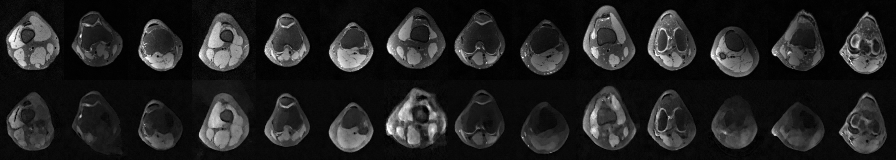

In [0]:
from PIL import Image

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

# img_start = "/content/nsf/bm3d_" + str(0)+ "_mirco.png"
# im = Image.open(img_start)
# for i in range(1, 14):
#   img_next = "/content/nsf/bm3d_" + str(i)+ "_mirco.png"
#   im_next = Image.open(img_next)
#   im = get_concat_h(im, im_next)

img_start2 = "/content/nsf/denoised_" + str(0)+ "_mirco.png"
im2 = Image.open(img_start2)
for i in range(1, 14):
  img_next2 = "/content/nsf/denoised_" + str(i)+ "_mirco.png"
  im_next2 = Image.open(img_next2)
  im2 = get_concat_h(im2, im_next2)


img_start_or = "/content/nsf/original_" + str(0)+ "_mirco.png"
im_or = Image.open(img_start_or)
for i in range(1, 14):
  img_next_or = "/content/nsf/original_" + str(i)+ "_mirco.png"
  im_next_or = Image.open(img_next_or)
  im_or = get_concat_h(im_or, im_next_or)  

# img_start_noisy = "/content/nsf/noisy_" + str(0)+ "_mirco.png"
# im_noisy = Image.open(img_start_noisy)
# for i in range(1, 8):
#   img_next_noisy = "/content/nsf/noisy_" + str(i)+ "_mirco.png"
#   im_next_noisy = Image.open(img_next_noisy)
#   im_noisy = get_concat_h(im_noisy, im_next_noisy)   


col = get_concat_v(im_or, im2)
# col = get_concat_v(col, im)
# col = get_concat_v(col, im2)

col